In [1]:
from nba_api.stats.endpoints import playercareerstats, playerdashboardbyyearoveryear
from nba_api.stats.static import teams, players
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Circle, Rectangle
import pandas as pd

In [2]:
nba_teams = teams.get_teams()
nba_players = players.get_players()
doncic_id = [player['id'] for player in nba_players if player['full_name'] == 'Luka Doncic'][0]
mavs_id = [team['id'] for team in nba_teams if team['full_name'] == 'Dallas Mavericks'][0]

In [3]:
def get_player_id(name):
    return [player['id'] for player in nba_players if player['full_name'] == name][0]

def get_team_id(name):
    return [team['id'] for team in nba_teams if team['full_name'] == name][0]

In [4]:
def draw_court(ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_xlim(0,500)
    ax.set_ylim(0,470)
    ax.invert_yaxis()
    
    hoop = Circle(xy=(250, 51.67), radius=7.5)
    backboard = Rectangle(xy=(220, 40), width=60, height=1)
    
    restricted_area = Arc(xy=(250, 51.67), width=80, height=80, theta1=0, theta2=180)
    outer_paint = Rectangle(xy=(170,0), width=160, height=190, fill=False)
    inner_paint = Rectangle(xy=(190,0), width=120, height=190, fill=False)
    
    free_throw_top = Arc(xy=(250, 190), width=120, height=120, theta1=180, theta2=0, linestyle='dashed')
    free_throw_bottom = Arc(xy=(250, 190), width=120, height=120, theta1=0, theta2=180)

    corner_three_left = Rectangle(xy=(30,0), width=1, height=140)
    corner_three_right = Rectangle(xy=(470,0), width=1, height=140)
    three_point_arc = Arc(xy=(250,50), width=476, height=476, theta1=22, theta2=158)
    
    center_outer = Arc(xy=(250,470), width=40, height=40, theta1=180, theta2=0)
    center_inner = Arc(xy=(250,470), width=120, height=120, theta1=180, theta2=0)
    
    features = [hoop, backboard, restricted_area, outer_paint, inner_paint, free_throw_top, free_throw_bottom, corner_three_left, corner_three_right, three_point_arc, center_inner, center_outer]
    
    for feature in features:
        ax.add_patch(feature)
        
    return ax

## Player Career Stats

In [5]:
def get_player_career_stats(name, stat_mode='Totals', season_type='Regular Season', year_by_year=False):
    player_id = get_player_id(name)
    if year_by_year:
        if season_type == 'Regular Season':
            return playercareerstats.PlayerCareerStats(player_id=player_id, per_mode36=stat_mode).get_data_frames()[0]
        if season_type == 'Post Season':
            return playercareerstats.PlayerCareerStats(player_id=player_id, per_mode36=stat_mode).get_data_frames()[2]
    else:
        if season_type == 'Regular Season':
            return playercareerstats.PlayerCareerStats(player_id=player_id, per_mode36=stat_mode).get_data_frames()[1]
        if season_type == 'Post Season':
            return playercareerstats.PlayerCareerStats(player_id=player_id, per_mode36=stat_mode).get_data_frames()[3]

## Player PPG Bar Graph

In [ ]:
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

In [ ]:
def players_stat_by_season(players, stat, start_season, end_season, season_type='Regular Season'):
    all_players_stats = []
    start_year = start_season.split('-')[0]
    end_year = end_season.split('-')[0]
    start_datetime = datetime.datetime.strptime(start_year, '%Y')
    end_datetime = datetime.datetime.strptime(end_year, '%Y')
    time_range_difference = (relativedelta(end_datetime, start_datetime)).years
    seasons = []
    for i in range(0, time_range_difference+1):
        seasons.append(f"{int(start_year)+i}-{int(start_year[-2:])+i+1}")
    for player in players:
        final_current_player_stats = []
        player_stats_with_season = []
        player_stats = get_player_career_stats(name=player, season_type=season_type, year_by_year=True)
        for i in range(len(player_stats)):
            player_stats_with_season.append((player_stats.loc[i]['SEASON_ID'], player_stats.loc[i][stat]))
        for season in seasons:
            found = 0
            for season_stat in player_stats_with_season:
                if season_stat[0].find(season) != -1:
                    found = 1
                    final_current_player_stats.append(season_stat[1])
                    break
            if (found == 0):
                final_current_player_stats.append(0)
        all_players_stats.append(final_current_player_stats)
    return all_players_stats, seasons

In [ ]:
def bargraph_players_stats_by_season(players, stat, start_season, end_season, season_type='Regular Season'):
    plt.style.use('seaborn-v0_8-darkgrid')
    
    player_stats, seasons = players_stat_by_season(players, stat, start_season=start_season, end_season=end_season, season_type=season_type)
    if (len(seasons) > 5 or len(players) > 5):
        print("Use a range of 5 seasons/players or less for the best graph results.")
        return 0
    x_indexes = np.arange(len(seasons))
    width = 1 / (len(players)+1)
    start = int(-(len(players)/2))
    end = int((len(players)+1)/2) if len(players)%2 else int(len(players)/2)
    
    j = 0
    colors = [(0.9,0,0, 0.8), 'blue', 'green', 'orange', 'yellow']
    for i in range(start, end):
        bars = plt.bar(x_indexes + i*width, player_stats[j], width=width, label=players[j])
        plt.bar_label(bars)
        j+=1
        
    plt.xticks(ticks=x_indexes, labels=seasons)
    plt.title(f'{stat} by Season')
    plt.xlabel('Season')
    plt.ylabel(stat)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

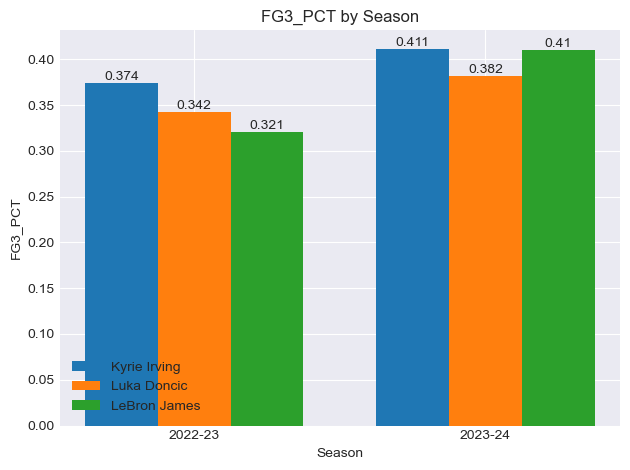

In [ ]:
bargraph_players_stats_by_season(players=['Kyrie Irving', 'Luka Doncic', 'LeBron James'],
                     stat='FG3_PCT',
                     start_season='2022-23',
                     end_season='2023-24',
                     season_type='Regular Season')

## Stat Leaders

In [ ]:
from nba_api.stats.endpoints import alltimeleadersgrids

In [ ]:
def all_time_leaders(stat, season_type='Regular Season', top_x=5):
    mapping = {'GP': 0, 'PTS': 1, 'AST': 2, 'STL': 3, 'OREB': 4, 'DREB': 5, 'REB': 6, 'BLK': 7, 'FGM': 8, 'FGA': 9, 'FG_PCT': 10, 'TOV': 11, 'FG3M': 12, 'FG3A': 13, 'FG3_PCT': 14, 'PF': 15, 'FTM': 16, 'FTA': 17, 'FT_PCT': 18}
    leader_stats = alltimeleadersgrids.AllTimeLeadersGrids(season_type=season_type, topx=top_x).get_data_frames()[mapping[stat]]
    return leader_stats

In [ ]:
def display_stat_leaders(stat, season_type='Regular Season', top_x=5):
    leaders = all_time_leaders(stat=stat, season_type=season_type, top_x=top_x)
    stats = leaders[stat]
    players = leaders['PLAYER_NAME']
    fig, ax = plt.subplots()
    bars = plt.bar(players, stats)
    plt.bar_label(bars)
    plt.xticks(fontsize=10)
    fig.autofmt_xdate()
    ax.invert_xaxis()
    plt.show()

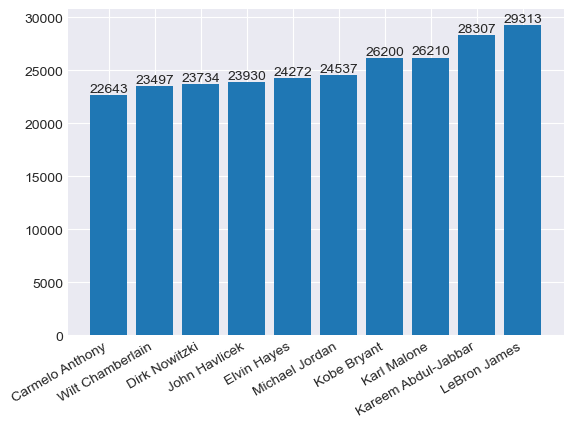

In [ ]:
display_stat_leaders('FGA', top_x=10)

## Shooting Related Stats

### FGA% / FG% from distance range

In [ ]:
from nba_api.stats.endpoints import teamdashboardbyshootingsplits, playerdashboardbyshootingsplits

In [ ]:
def player_fga_per_distance_range(player, distance_range, season, stat='FGA', season_type='Regular Season'):
    player_id = get_player_id(player)
    if distance_range == 'By Zone':
        player_shooting_stats = playerdashboardbyshootingsplits.PlayerDashboardByShootingSplits(player_id=player_id,
                                                                                                season=season,
                                                                                                season_type_playoffs=season_type).get_data_frames()[3]
    elif distance_range == '8ft':
        player_shooting_stats = playerdashboardbyshootingsplits.PlayerDashboardByShootingSplits(player_id=player_id,
                                                                                                season=season,
                                                                                                season_type_playoffs=season_type).get_data_frames()[2]
    else:
        player_shooting_stats = playerdashboardbyshootingsplits.PlayerDashboardByShootingSplits(player_id=player_id,
                                                                                                season=season,
                                                                                                season_type_playoffs=season_type).get_data_frames()[1]
    shooting_zones = player_shooting_stats['GROUP_VALUE'].tolist()
    if stat == 'FG_PCT':
        fg_stats = player_shooting_stats[stat].tolist()
    else:
        total_fga = sum(player_shooting_stats[stat].tolist())
        fg_stats = player_shooting_stats[stat].tolist()
        fg_stats = [round((fga/total_fga)*100, 1) for fga in fg_stats]
    
    return fg_stats, shooting_zones

In [ ]:
def team_fga_per_distance_range(team, distance_range, season, stat='FGA', season_type='Regular Season'):
    team_id = get_team_id(team)
    if distance_range == 'By Zone':
        team_shooting_stats = teamdashboardbyshootingsplits.TeamDashboardByShootingSplits(team_id=team_id,
                                                                                            season=season,
                                                                                            season_type_all_star=season_type).get_data_frames()[3]
    elif distance_range == '8ft':
        team_shooting_stats = teamdashboardbyshootingsplits.TeamDashboardByShootingSplits(team_id=team_id,
                                                                                            season=season,
                                                                                            season_type_all_star=season_type).get_data_frames()[2]
    else:
        team_shooting_stats = teamdashboardbyshootingsplits.TeamDashboardByShootingSplits(team_id=team_id,
                                                                                            season=season,
                                                                                            season_type_all_star=season_type).get_data_frames()[1]
    shooting_zones = team_shooting_stats['GROUP_VALUE'].tolist()
    if stat == 'FG_PCT':
        fg_stats = team_shooting_stats[stat].tolist()
    else:
        total_fga = sum(team_shooting_stats[stat].tolist())
        fg_stats = team_shooting_stats[stat].tolist()
        fg_stats = [round((fga/total_fga)*100, 1) for fga in fg_stats]
    
    return fg_stats, shooting_zones

In [ ]:
def graph_fga_per_distance_range(distance_range, season, stat='FG_PCT', season_type='Regular Season', player=None, team=None):
    if team is None:
        fg_stats, shooting_zones = player_fga_per_distance_range(player=player, distance_range=distance_range, stat=stat, season=season, season_type=season_type)
    else:
        fg_stats, shooting_zones = team_fga_per_distance_range(team=team, distance_range=distance_range, stat=stat, season=season, season_type=season_type)
    fig, ax = plt.subplots()
    bars = plt.bar(shooting_zones, fg_stats)
    ax.bar_label(bars)
    plt.title(f'{stat} Per Shooting Zone')
    plt.xlabel('Shooting Zone')
    plt.ylabel(stat)
    plt.xticks(fontsize=10)
    fig.autofmt_xdate()
    plt.show()

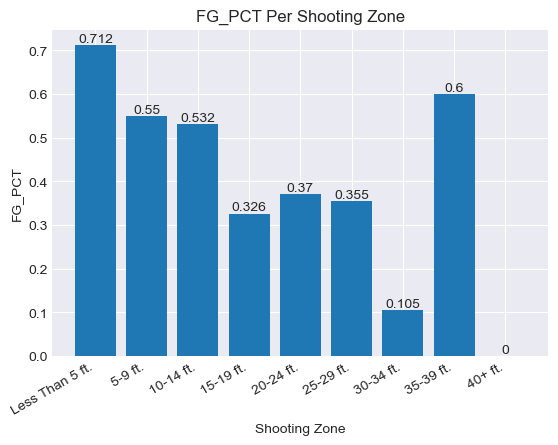

In [ ]:
graph_fga_per_distance_range(player='Luka Doncic', distance_range='5ft', stat='FG_PCT', season='2022-23')

### Game Shotchart

In [ ]:
from nba_api.stats.endpoints import playergamelog, shotchartdetail
import matplotlib.pyplot as plt

In [ ]:
game_log = playergamelog.PlayerGameLog(player_id=doncic_id, season='2023-24', season_type_all_star='Regular Season')
game_id = game_log.get_data_frames()[0].loc[0]['Game_ID']

In [ ]:
def game_shotchart(player, game_id, team_id):
    player_id = get_player_id(player)
    player_shotchart = shotchartdetail.ShotChartDetail(player_id=player_id, game_id_nullable=game_id, team_id=team_id, context_measure_simple='FGA').get_data_frames()[0]
    shot_coords = ((player_shotchart['LOC_X'] + 250).tolist(), (player_shotchart['LOC_Y'] + 47).tolist())
    shot_made_flags = player_shotchart['SHOT_MADE_FLAG'].tolist()
    shot_mapping = {0: 'x', 1: 'o'}
    color_mapping = {0: 'r', 1: 'g'}
    fig, ax = plt.subplots()
    ax = draw_court(ax)
    for i in range(len(shot_coords[0])):
        ax.scatter(shot_coords[0][i], shot_coords[1][i], marker=shot_mapping[shot_made_flags[i]], c=color_mapping[shot_made_flags[i]])
    
    plt.axis(False)
    plt.show()
    

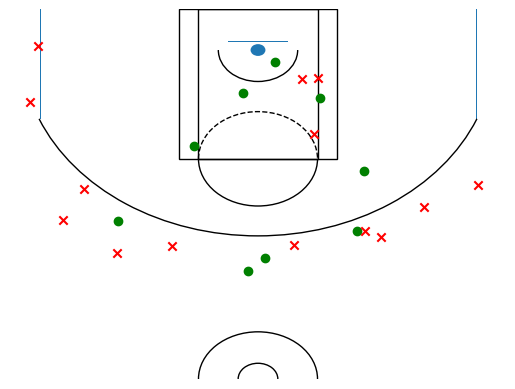

In [ ]:
game_shotchart(player='Luka Doncic', game_id=game_id, team_id=mavs_id)

## Player Season Shooting Heatmap 

In [ ]:
from nba_api.stats.endpoints import shotchartdetail
import seaborn as sns
import numpy as np

In [ ]:
def player_shooting_heatmap(player, season, team_id):
    player_id = get_player_id(player)
    player_shotchart = shotchartdetail.ShotChartDetail(player_id=player_id, season_nullable=season, team_id=team_id, context_measure_simple='FGA').get_data_frames()[0]
    player_shot_locations = player_shotchart[['LOC_X', 'LOC_Y']]
    player_shot_locations.loc[:, 'LOC_X'] = player_shot_locations.loc[:, 'LOC_X'] + 250
    player_shot_locations.loc[:, 'LOC_Y'] = player_shot_locations.loc[:, 'LOC_Y'] + 47
    
    outliers = player_shot_locations[player_shot_locations["LOC_Y"] > 470].index
    player_shot_locations = player_shot_locations.drop(outliers)
    x_locs = player_shot_locations['LOC_X'].tolist()
    y_locs = player_shot_locations['LOC_Y'].tolist()
    shot_coords = list(zip(x_locs,y_locs))
    
    coord_matrix = np.zeros((500+1, 470+1), dtype=int)
    for i, j in shot_coords:
        coord_matrix[i,j] += 1
        
    coords_df = pd.DataFrame(coord_matrix).transpose()
    coords_df.drop(coords_df.columns[len(coords_df.columns)-1], axis=1, inplace=True)
    coords_df.drop(coords_df.tail(1).index, inplace=True)
    
    step = 5
    for i in np.arange(0, 500, step):
        coords_df[i] = coords_df[i] + coords_df[i+1] + coords_df[i+2] + coords_df[i+3] + coords_df[i+4]
        coords_df.drop(axis=1, labels=[i+1, i+2, i+3, i+4], inplace=True)
    
    coords_df = coords_df.transpose()

    for i in np.arange(0, 470, step):
        coords_df[i] = coords_df[i] + coords_df[i+1] + coords_df[i+2] + coords_df[i+3] + coords_df[i+4]
        coords_df.drop(axis=1, labels=[i+1, i+2, i+3, i+4], inplace=True)
        
    coords_df = coords_df.transpose()
    
    fig, ax = plt.subplots()
    sns.heatmap(coords_df, cmap='magma', square=True)
    ax.axis(False)
    ax.set_title(f'{player} Shooting Heatmap')

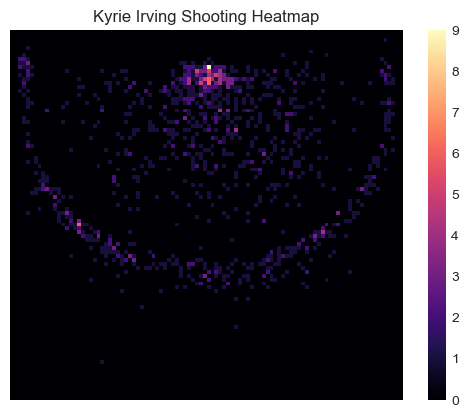

In [ ]:
player_shooting_heatmap('Kyrie Irving', '2023-24', mavs_id)